In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lorenz/lorenz.txt
/kaggle/input/wwwusage/WWWusage.csv
/kaggle/input/www-usage/WWWusage.csv


In [2]:
import pandas as pd

# Read a CSV file into a pandas DataFrame
df = pd.read_csv('/kaggle/input/www-usage/WWWusage.csv', names=['value'], header=0)

# Print the total number of samples in the DataFrame
print(f"Total samples: {len(df)}")

# Print the first few rows of the DataFrame
print(df.head())


Total samples: 100
     value
1 1     88
2 2     84
3 3     85
4 4     85
5 5     84


<Axes: >

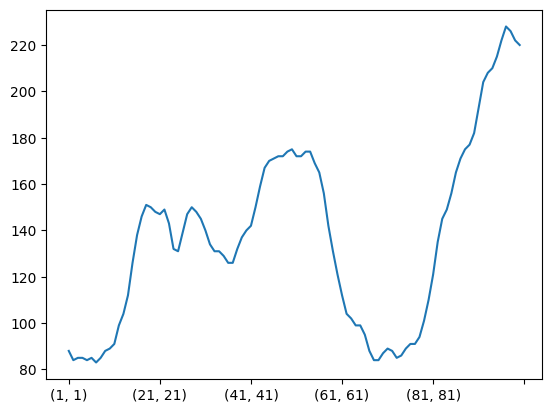

In [19]:
df['value'].plot()

Three factors define ARIMA model, it is defined as ARIMA(p,d,q) where p, d, and q denote the number of lagged (or past) observations to consider for autoregression, the number of times the raw observations are differenced, and the size of the moving average window respectively.


The first step would be to take care of the properties of the time series. For that, we need to determine the order of differencing “d.” Let’s first check the autocorrelation plot. The statsmodel package can help us with this.

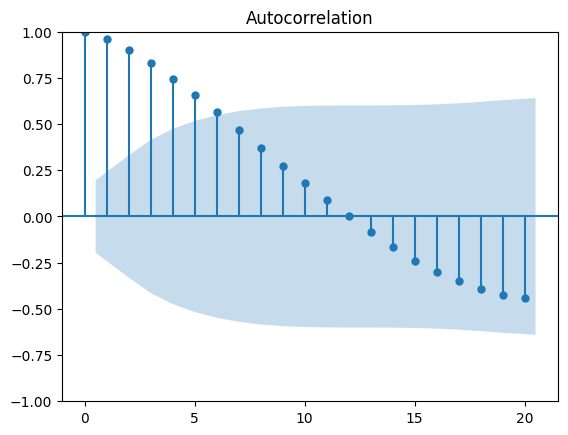

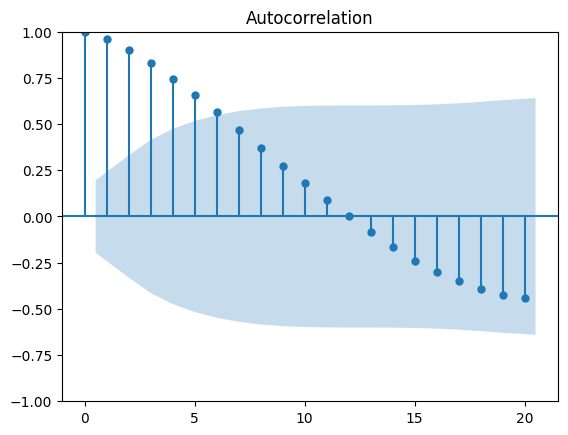

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.value)

Clearly, the data is not ideal for the Python ARIMA model to directly start autoregressive training. So let’s see how the differencing segment of ARIMA model Python makes the data stationary.

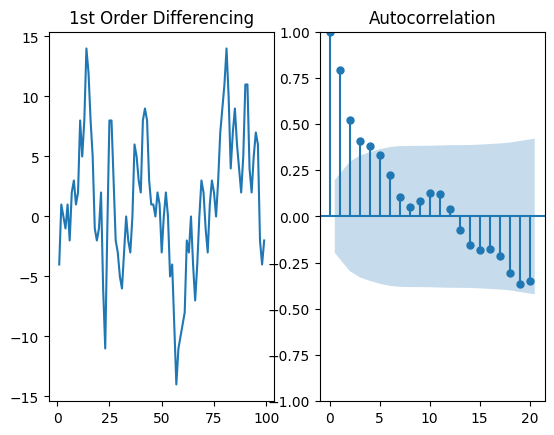

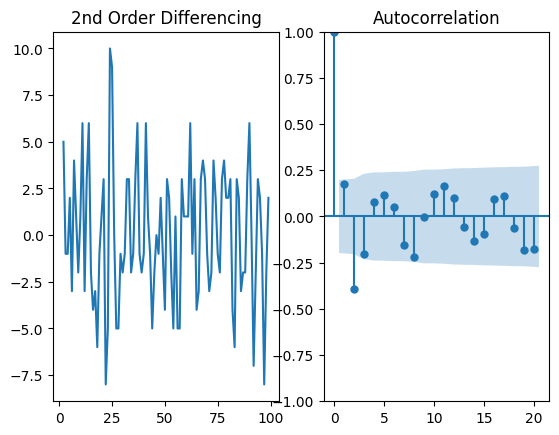

In [6]:
import matplotlib.pyplot as plt
# First order differencing plot and autocorrelation
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df.value.diff().values)

ax2 = f.add_subplot(122)
plot_acf(df.value.diff().dropna(), ax=ax2)
plt.show()

# Second order differencing plot and autocorrelation
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(df.value.diff().diff().values)

ax2 = f.add_subplot(122)
plot_acf(df.value.diff().diff().dropna(), ax=ax2)
plt.show()

From the autocorrelation graph, we can decide if more differencing is needed. If collectively the autocorrelations, or the data point of each lag (in the horizontal axis), are positive for several consecutive lags, more differencing might be needed. Conversely, if more data points are negative, the series is over-differenced.

If the p-value is less than 0.05, then the data is stationary; else, the differencing order is incremented by one.

In [7]:
from statsmodels.tsa.stattools import adfuller
# Augmented Dickey-Fuller test to check stationarity
result = adfuller(df.value.dropna())
print('p-value: ', result[1])

result = adfuller(df.value.diff().dropna())
print('p-value: ', result[1])

result = adfuller(df.value.diff().diff().dropna())
print('p-value: ', result[1])

p-value:  0.12441935447109481
p-value:  0.07026846015272718
p-value:  2.843428755547158e-17


As we see above, after the 2nd order differencing, the p-value drops beyond the acceptable threshold.

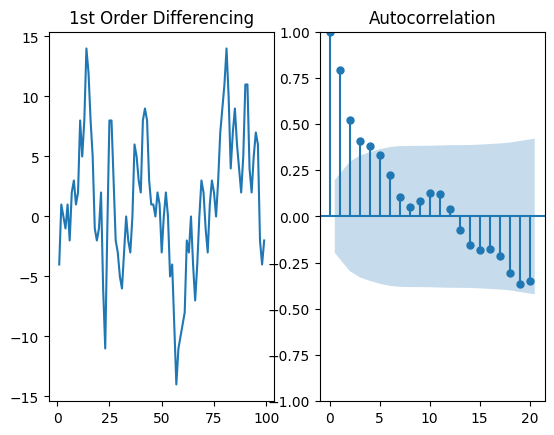

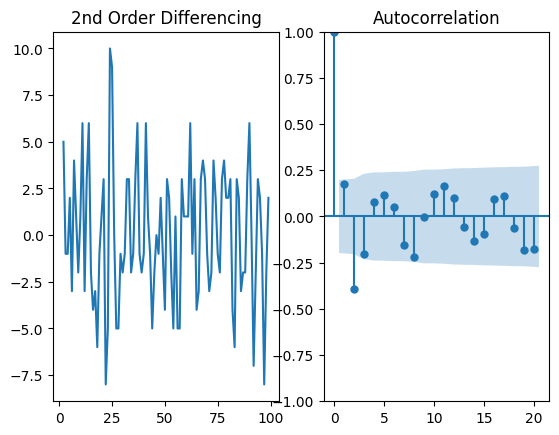

In [8]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df.value.diff().values)

ax2 = f.add_subplot(122)
plot_acf(df.value.diff().dropna(), ax=ax2)
plt.show()

# Second order differencing plot and autocorrelation
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(df.value.diff().diff().values)

ax2 = f.add_subplot(122)
plot_acf(df.value.diff().diff().dropna(), ax=ax2)
plt.show()

# How to Fit ARIMA?

Using the ARIMA class from the statsmodels.tsa.arima_model module, we can feed the data and the hyperparameters p, d, and q to it (in that order)

In [9]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# ARIMA models with different orders
# Model with ARIMA(1,1,2)
arima_model = ARIMA(df.value, order=(1,1,2))
model = arima_model.fit()
print(model.summary())




                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Fri, 22 Dec 2023   AIC                            516.253
Time:                        05:45:19   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


As seen above, the model summary provides several statistical measures to evaluate the performance of ARIMA model in Python. Moreover, we also know the coefficient values for each of the parameters.

In [10]:
# Model with ARIMA(1,2,2)
arima_model = ARIMA(df.value, order=(1,2,2))
model = arima_model.fit()
print(model.summary())



/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -252.594
Date:                Fri, 22 Dec 2023   AIC                            513.189
Time:                        05:45:20   BIC                            523.529
Sample:                             0   HQIC                           517.371
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6530      0.103      6.359      0.000       0.452       0.854
ma.L1         -0.4745      3.083     -0.154      0.878      -6.517       5.568
ma.L2         -0.5251      1.598     -0.329      0.7

In [11]:
# Model with ARIMA(1,1,3)
arima_model = ARIMA(df.value, order=(1,1,3))
model = arima_model.fit()
print(model.summary())



                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -252.289
Date:                Fri, 22 Dec 2023   AIC                            514.577
Time:                        05:45:20   BIC                            527.553
Sample:                             0   HQIC                           519.827
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8580      0.129      6.651      0.000       0.605       1.111
ma.L1          0.3429      0.174      1.971      0.049       0.002       0.684
ma.L2         -0.2852      0.197     -1.447      0.1

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Plot ARIMA Forecast Results

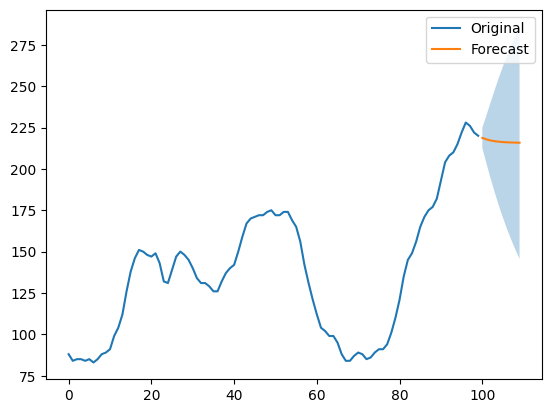

In [12]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(df['value'].values, order=(1, 1, 2))
model_fit = model.fit()

# Forecast
forecast = model_fit.get_forecast(steps=10)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the forecast
fig, ax = plt.subplots()
ax.plot(df['value'].values, label='Original')
ax.plot(range(len(df), len(df) + len(forecast_values)), forecast_values, label='Forecast')
ax.fill_between(range(len(df), len(df) + len(forecast_values)),
                forecast_conf_int[:, 0],
                forecast_conf_int[:, 1],
                alpha=0.3)

plt.legend()
plt.show()

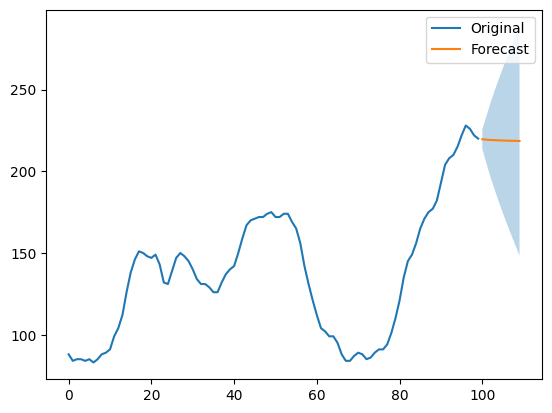

In [13]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(df['value'].values, order=(1, 1, 3))
model_fit = model.fit()

# Forecast
forecast = model_fit.get_forecast(steps=10)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the forecast
fig, ax = plt.subplots()
ax.plot(df['value'].values, label='Original')
ax.plot(range(len(df), len(df) + len(forecast_values)), forecast_values, label='Forecast')
ax.fill_between(range(len(df), len(df) + len(forecast_values)),
                forecast_conf_int[:, 0],
                forecast_conf_int[:, 1],
                alpha=0.3)

plt.legend()
plt.show()

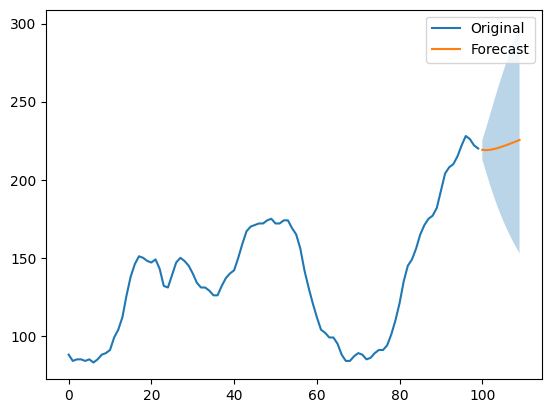

In [14]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(df['value'].values, order=(1, 2, 2))
model_fit = model.fit()

# Forecast
forecast = model_fit.get_forecast(steps=10)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the forecast
fig, ax = plt.subplots()
ax.plot(df['value'].values, label='Original')
ax.plot(range(len(df), len(df) + len(forecast_values)), forecast_values, label='Forecast')
ax.fill_between(range(len(df), len(df) + len(forecast_values)),
                forecast_conf_int[:, 0],
                forecast_conf_int[:, 1],
                alpha=0.3)

plt.legend()
plt.show()

In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pprint import pprint

arima_model_1 = ARIMA(df.value[:80], order=(1,1,2))
model_1 = arima_model_1.fit()
print(model_1.summary())




                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   80
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -203.020
Date:                Fri, 22 Dec 2023   AIC                            414.041
Time:                        05:45:21   BIC                            423.518
Sample:                             0   HQIC                           417.838
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5732      0.186      3.078      0.002       0.208       0.938
ma.L1          0.5533      0.207      2.668      0.008       0.147       0.960
ma.L2          0.0617      0.189      0.326      0.7

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [16]:
arima_model_2 = ARIMA(df.value[:80], order=(1,2,2))
model_2 = arima_model_2.fit()
print(model_2.summary())



/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   80
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -201.756
Date:                Fri, 22 Dec 2023   AIC                            411.512
Time:                        05:45:22   BIC                            420.938
Sample:                             0   HQIC                           415.285
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6477      0.113      5.718      0.000       0.426       0.870
ma.L1         -0.5207      5.434     -0.096      0.924     -11.172      10.130
ma.L2         -0.4789      2.577     -0.186      0.8

# Evaluation and Prediction

Let us consider the first 80 of 100 samples for fitting the model.

In [17]:
y_pred = model_fit.predict(start=80, end=89)  # Predicting the next 10 values
y_true = df['value'].values[80:90]  # True values for the next 10 values

# Conversion to NumPy arrays
y_pred_np = np.array(y_pred)
y_true_np = np.array(y_true)

# Calculation of various error metrics
mape = np.mean(np.abs((y_pred_np - y_true_np) / np.abs(y_true_np)))  # Mean Absolute Percentage Error
mae = np.mean(np.abs(y_pred_np - y_true_np))  # Mean Absolute Error
mpe = np.mean((y_pred_np - y_true_np) / y_true_np)  # Mean Percentage Error
rmse = np.mean((y_pred_np - y_true_np)**2)**0.5  # Root Mean Square Error
corr = np.corrcoef(y_pred_np, y_true_np)[0, 1]  # Correlation Coefficient

mins = np.amin(np.hstack([y_pred_np[:, None], y_true_np[:, None]]), axis=1)
maxs = np.amax(np.hstack([y_pred_np[:, None], y_true_np[:, None]]), axis=1)
minmax = 1 - np.mean(mins / maxs)  # Min-Max Error

pprint({'mape': mape, 'mae': mae, 'mpe': mpe, 'rmse': rmse, 'corr': corr, 'minmax': minmax})

# Theil's U statistic
n = len(df.value[:80])
d = np.abs(np.diff(df.value[:80].values)).sum() / (n-1)
errors = np.abs(y_true_np - y_pred_np)
print(errors.mean()/d)

{'corr': 0.9915936405037643,
 'mae': 2.489122307577122,
 'mape': 0.016672488832761127,
 'minmax': 0.016634751747657495,
 'mpe': -0.009335397635860176,
 'rmse': 2.974616538015424}
0.6106852866415919


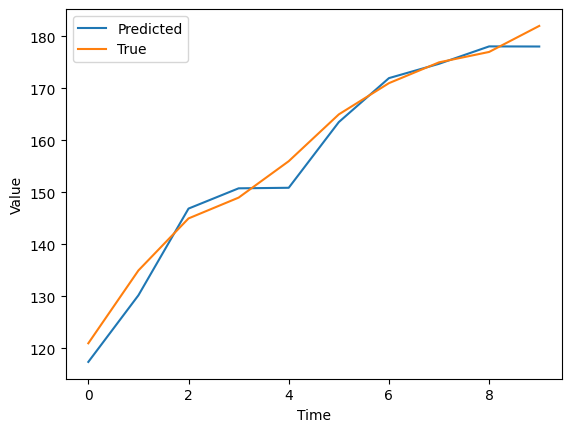

In [18]:
import numpy as np
import matplotlib.pyplot as plt

y_pred = model_fit.predict(start=80, end=89)  # Example: Predicting the next 10 values
y_true = df['value'].values[80:90]  

y_pred_np = np.array(y_pred)
y_true_np = np.array(y_true)

plt.plot(y_pred_np, label='Predicted')
plt.plot(y_true_np, label='True')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()